In [1]:
import torch.nn.functional as F
from torch import optim
from forestFire import ForestFire
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from actor_critic import ActorCritic
from helper_functions import plot_train_rewards, plot_test_rewards

## Setup replay memory object

In [2]:
class ReplayMemory:
    def __init__(self, size):
        self.buffer = []
        self.max_size = size
        self.oldest_transition = 0

    def sample(self, mb):
        return random.sample(self.buffer, mb)

    def new_transition(self, s, a, r, s_p):
        data = [s, a, r, s_p]
        # Check if buffer is full
        if len(self.buffer) == self.max_size:
            # Replace oldest value in the buffer
            self.buffer[self.oldest_transition] = data
            self.oldest_transition += 1
            if self.oldest_transition == self.max_size:
                self.oldest_transition = 0
        else:
            # Append to the end of buffer
            self.buffer.append(data)

# Create Neural Network for DQN

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ForestFireDQN(nn.Module):
    def __init__(self, input_size):
        super(ForestFireDQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=32),
            nn.ReLU(True),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features=4),
        )


    def forward(self, x):
        x.to(device)
        return self.network(x)

# Add Training For DQN

In [6]:
# Defining Constants
max_episodes = 1000
gamma = 0.99
C = 5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        if done:
            memory.new_transition(s=state, a=action, r=reward, s_p=None)
        else:
            memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = transition[3]
                # Compute target
                if s_p is None:
                    y_j = r
                    targets.append(torch.tensor(y_j))
                else:
                    trans_Q_values = target_policy(torch.Tensor(s_p))
                    max_trans_Q = max(trans_Q_values)
                    y_j = r + (gamma * max_trans_Q)
                    targets.append(y_j)
                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets).to(torch.float32)
            estimations_s = torch.stack(estimations).to(torch.float32)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # Update the weights of target policy every C episodes
    if episode % C == 0:
        target_policy.load_state_dict(main_policy.state_dict())
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(total_rewards[-100:]).mean()}')
    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    # End Training

Mean reward after episode 100: -23.2
Mean reward after episode 200: 12.2
Mean reward after episode 300: 24.3
Mean reward after episode 400: 39.4
Mean reward after episode 500: 46.2
Mean reward after episode 600: 49.7
Mean reward after episode 700: 45.9
Mean reward after episode 800: 48.0
Mean reward after episode 900: 47.7
Mean reward after episode 1000: 52.8


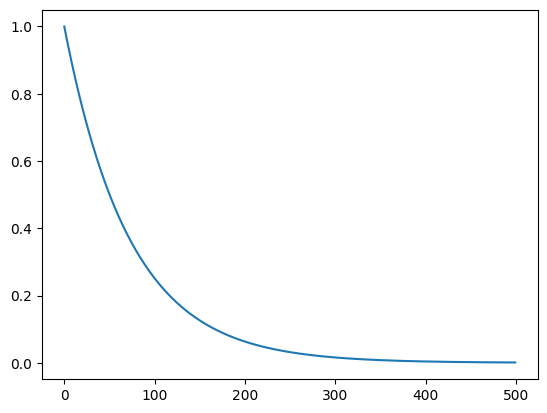

In [6]:
plt.plot(total_epsilons)

In [ ]:
pltsave = 0

In [ ]:
plt.plot(total_rewards)
plt.savefig(('savedFigures/reward_graph' + str(pltsave) + '.png'))
pltsave += 1

Created directory: savedPlots/trial1
Created directory: savedPlots/trial2
Created directory: savedPlots/trial3
Created directory: savedPlots/trial4
Created directory: savedPlots/trial5
Created directory: savedPlots/trial6
Created directory: savedPlots/trial7
Created directory: savedPlots/trial8
Created directory: savedPlots/trial9
Created directory: savedPlots/trial10


<Figure size 640x480 with 0 Axes>

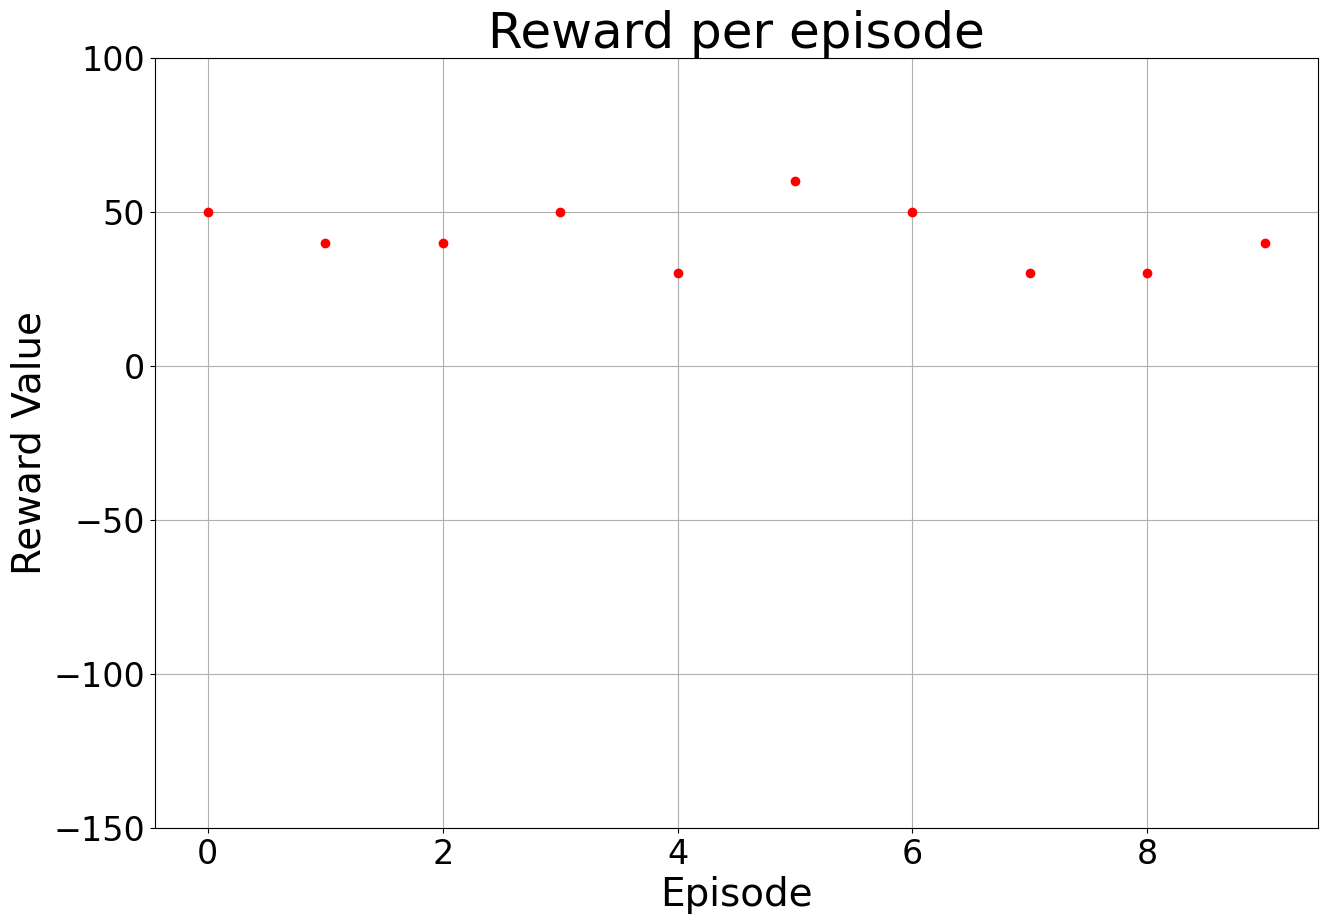

<Figure size 640x480 with 0 Axes>

In [5]:
environment_name = 'forest_fire'
algorithm_name = 'Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
test_rewards = []
test_env = ForestFire(10, 10, obs_type='complex', save_results=True)
for i in range(n_episodes_test):
    obs = test_env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = test_env.step(action)
            reward += rew
            obs = new_obs
            render = test_env.render(plot=False)

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

# Add Training For Double DQN

In [26]:
# Defining Constants
max_episodes = 10000
gamma = 0.99
C = 25
tau = 0.5

# Epsilon Decay
epsilon = 1
final_epsilon = 0.001
decay_factor = (final_epsilon/epsilon)**(1/max_episodes)

# Initializing Replay Memory and minibatch size
memory = ReplayMemory(size=10000)
minibatch_size = 10

# Initialize Environment
environment = ForestFire(height=10, width=10, obs_type='complex')

# Initialize Policies and set weights equal
main_policy = ForestFireDQN(16)
target_policy = ForestFireDQN(16)
target_policy.load_state_dict(main_policy.state_dict())

# Initialize Optimizer for Gradient Descent
optimizer = optim.Adam(params=main_policy.parameters(), lr=1e-3)

# Lists to keep track of Cumulative Reward and Epsilon Decay
total_rewards = []
total_epsilons = []

# Train for M episodes
for episode in range(1, max_episodes+1):
    state = environment.reset()
    cumulative_reward = 0
    done = False
    steps = 0
    while not done:
        steps += 1
        # environment.render()
        # Using epsilon-greedy policy, choose an action a
        action = 0
        probability = random.random()
        if probability < epsilon:
            # Choose random action
            action = environment.action_space.sample()
        else:
            # Choose action with highest likelihood
            Q_values = main_policy(torch.Tensor(state))
            action = torch.argmax(Q_values)

        # Take action and observe new state s' and reward r
        new_state, reward, done = environment.step(action=action)

        # Store the new transition in replay memory D
        memory.new_transition(s=state, a=action, r=reward, s_p=new_state)

        # If there is enough transitions in the replay memory, optimize
        if len(memory.buffer) >= minibatch_size and steps % C == 0:
            batch = memory.sample(minibatch_size)
            targets = []
            estimations = []
            for transition in batch:
                s = transition[0]
                a = transition[1]
                r = transition[2]
                s_p = torch.Tensor(transition[3])
                # Compute target
                argmax_Q_main = torch.argmax(main_policy(torch.Tensor(s_p)))
                target_Q = target_policy(s_p)[argmax_Q_main]
                y_j = r + gamma * target_Q
                targets.append(y_j)

                # Compute estimation
                estimation = main_policy(torch.Tensor(s))[a]
                estimations.append(estimation)
            # compute Mean Squared Error and Back propagate
            targets_s = torch.stack(targets)
            estimations_s = torch.stack(estimations)
            criterion = nn.MSELoss()
            loss = criterion(estimations_s, targets_s)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update target network parameters
            for i in range(len(list(main_policy.parameters()))):
              primary_theta = list(main_policy.parameters())[i].clone()
              primary_theta = torch.multiply(primary_theta, tau)
              target_theta = list(target_policy.parameters())[i].clone()
              target_theta = torch.multiply(target_theta, (1 - tau))
              list(target_policy.parameters())[i] = torch.add(target_theta, primary_theta)

        # Add reward to cumulative reward
        cumulative_reward += reward

        # Set state to the next
        state = new_state

        # End Episode
    total_rewards.append(cumulative_reward)

    # Update Epsilon Value
    total_epsilons.append(epsilon)
    epsilon *= decay_factor

    # print('Episode', episode, 'Reward:', cumulative_reward, 'Steps:', steps)
    if episode % 100 == 0:
        print(f'Mean reward after episode {episode}: {np.array(total_rewards[-100:]).mean()}')
    # End Training

Mean reward after episode 100: -37.6
Mean reward after episode 200: -44.2
Mean reward after episode 300: -27.4
Mean reward after episode 400: -25.9
Mean reward after episode 500: -14.1
Mean reward after episode 600: -15.2
Mean reward after episode 700: -14.3
Mean reward after episode 800: -1.4
Mean reward after episode 900: 0.4
Mean reward after episode 1000: 2.4
Mean reward after episode 1100: 1.3
Mean reward after episode 1200: -1.0
Mean reward after episode 1300: 1.9
Mean reward after episode 1400: 4.8
Mean reward after episode 1500: 14.0
Mean reward after episode 1600: -0.7
Mean reward after episode 1700: 7.7
Mean reward after episode 1800: 7.7
Mean reward after episode 1900: 9.5
Mean reward after episode 2000: 11.0
Mean reward after episode 2100: 6.8
Mean reward after episode 2200: 17.8
Mean reward after episode 2300: 11.5
Mean reward after episode 2400: 12.5
Mean reward after episode 2500: 12.0
Mean reward after episode 2600: 17.5
Mean reward after episode 2700: 15.9
Mean reward 

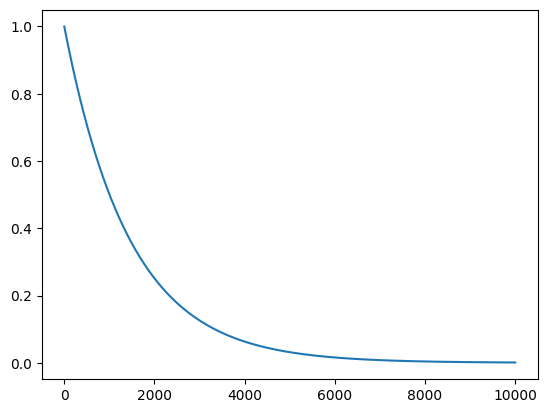

In [10]:
plt.plot(total_epsilons)

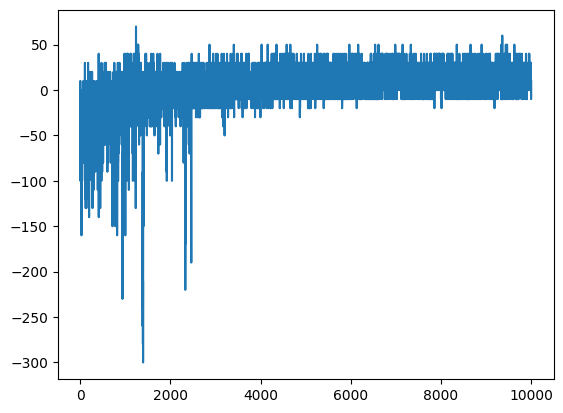

In [22]:
plt.plot(total_rewards)

<Figure size 640x480 with 0 Axes>

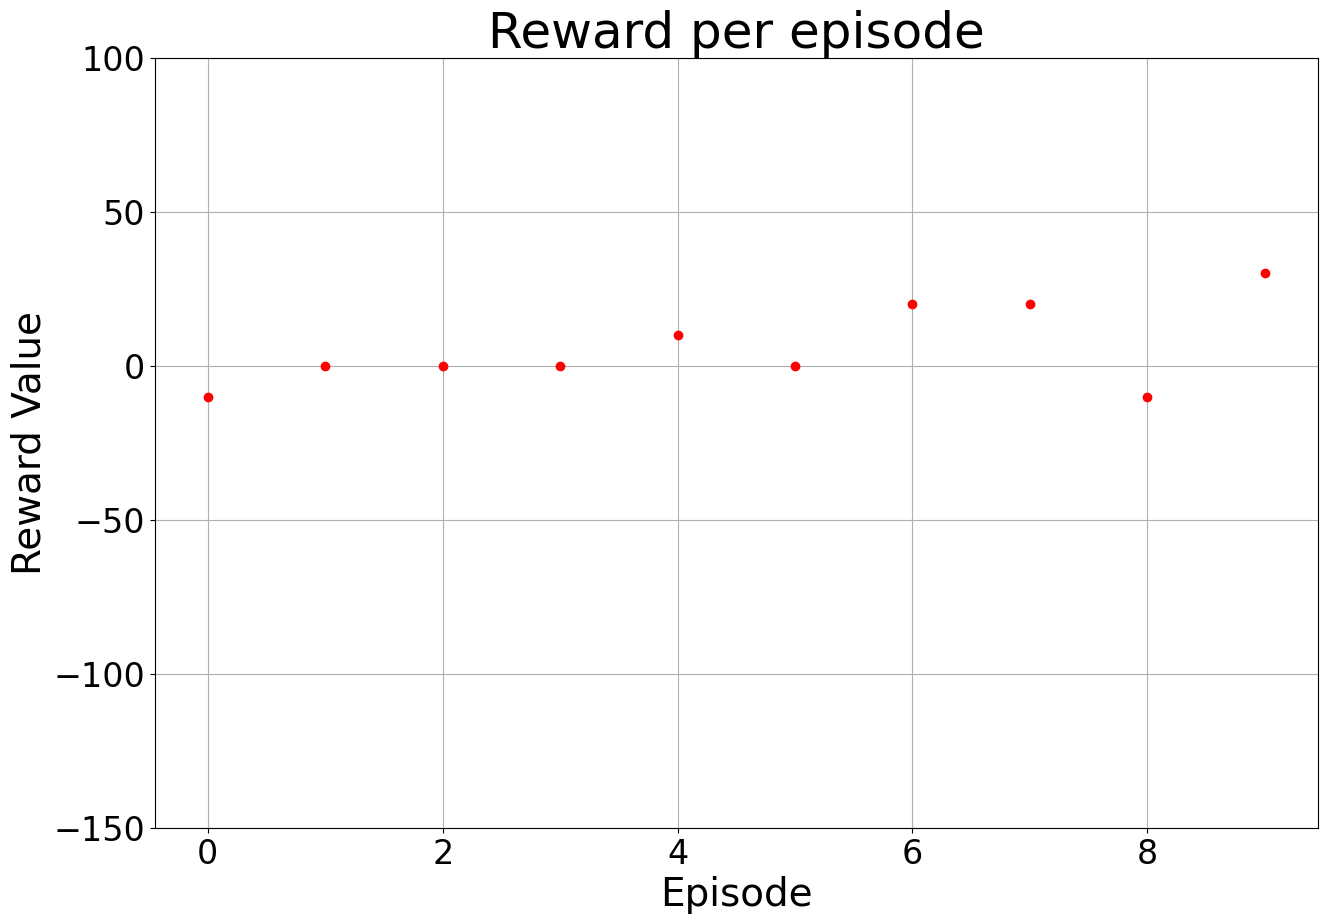

<Figure size 640x480 with 0 Axes>

In [25]:
environment_name = 'forest_fire'
algorithm_name = 'Dobule-Deep-Q-Learning'
min_reward = -150
max_reward = 100
n_episodes_test = 10
test_rewards = []
for i in range(n_episodes_test):
    obs = environment.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            Q_values = main_policy(torch.Tensor(obs))
            action = torch.argmax(Q_values)
            new_obs, rew, done = environment.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

# Trying Actor Critic from Project 3

In [1]:
env = ForestFire(height=10, width=10)
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 2000
episodic_rewards = []
environment_name = 'forest_fire'
algorithm_name = 'td_ac'
min_reward = -100
max_reward = 100

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

NameError: name 'ForestFire' is not defined

<Figure size 640x480 with 0 Axes>

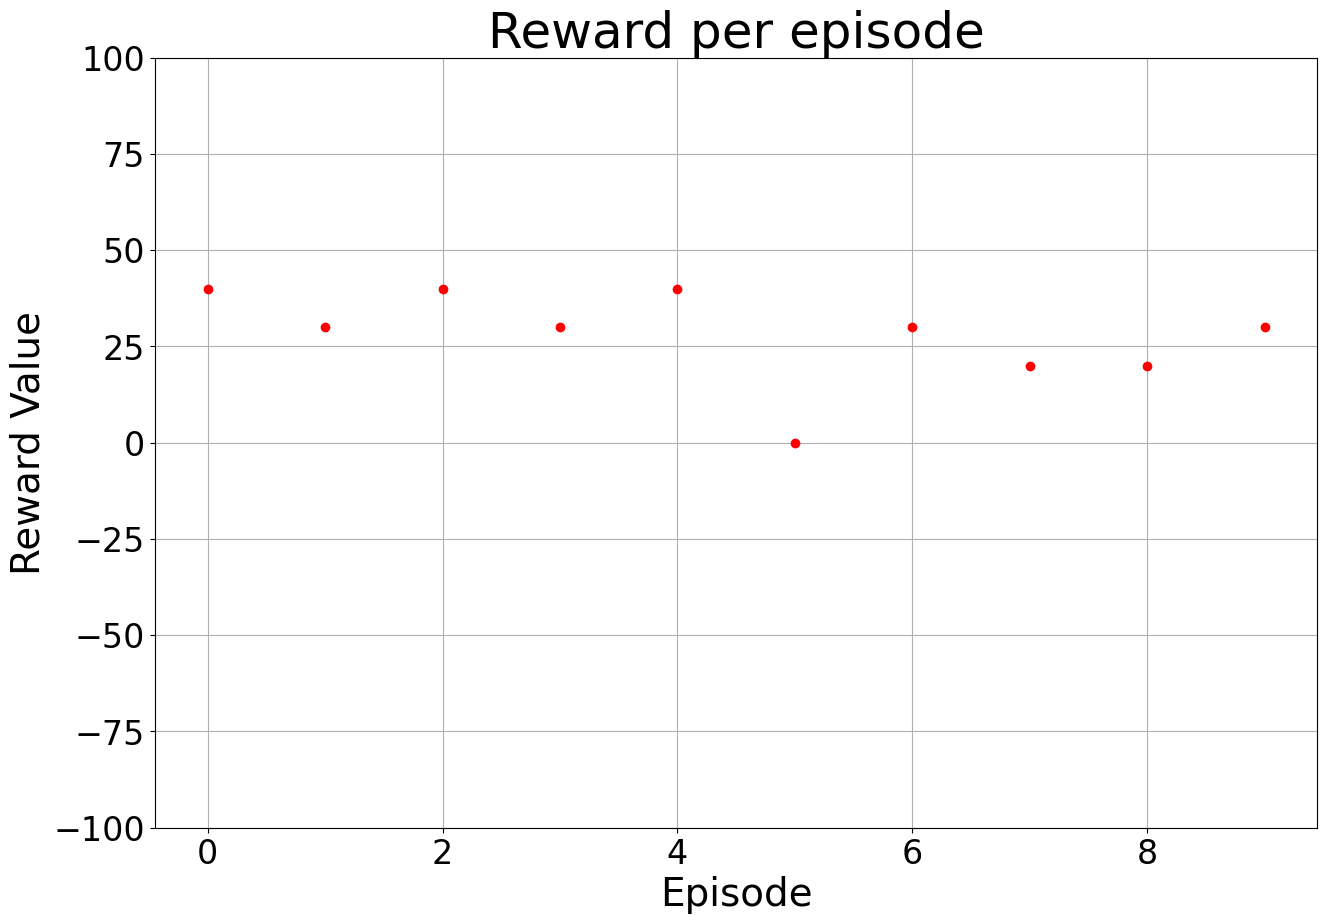

In [4]:
n_episodes_test = 10
test_rewards = []
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

# Actor Critic on more complex observation

Mean reward after episode 0: -40.0
Mean reward after episode 100: -1.0
Mean reward after episode 200: 20.1
Mean reward after episode 300: 32.6
Mean reward after episode 400: 33.7
Mean reward after episode 500: 38.2
Mean reward after episode 600: 39.3
Mean reward after episode 700: 38.6
Mean reward after episode 800: 46.6
Mean reward after episode 900: 43.9
Mean reward after episode 1000: 44.8
Mean reward after episode 1100: 46.9
Mean reward after episode 1200: 44.9
Mean reward after episode 1300: 49.3
Mean reward after episode 1400: 47.2
Mean reward after episode 1500: 47.9
Mean reward after episode 1600: 43.4
Mean reward after episode 1700: 48.1
Mean reward after episode 1800: 52.4
Mean reward after episode 1900: 45.1


<Figure size 640x480 with 0 Axes>

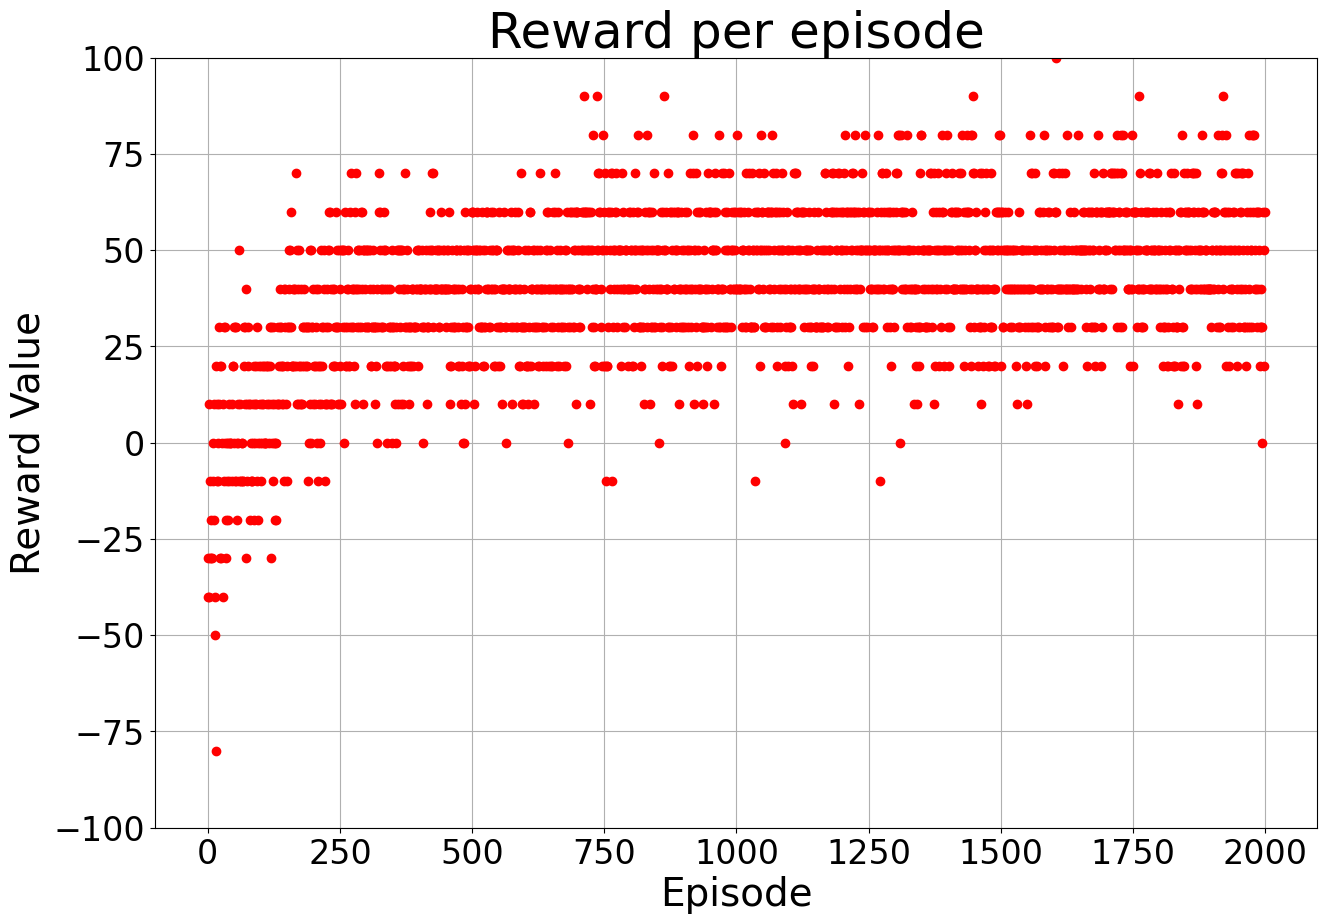

In [5]:
env = ForestFire(height=10, width=10, obs_type='complex')
actor_critic = ActorCritic(env.observation_space.shape[0], env.action_space.n, actor_lr=2e-4, critic_lr=1e-3, dense=True)
n_episodes = 2000
episodic_rewards = []
environment_name = 'forest_fire_complex'
algorithm_name = 'td_ac'
min_reward = -100
max_reward = 100

# Training the agent
for i in range(n_episodes):
    obs = env.reset()
    done = False
    reward = 0
    while not done:
        action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
        new_obs, rew, done = env.step(action)
        reward += rew
        actor_critic.learn(
            torch.from_numpy(obs).float().unsqueeze(0),
            action,
            log_probability,
            rew,
            torch.from_numpy(new_obs).float().unsqueeze(0),
            done
        )
        obs = new_obs

    episodic_rewards.append(reward)
    if(np.all(np.array(episodic_rewards[-10:]) >= 100)):
        break
    if(i%100 == 0):
        print(f'Mean reward after episode {i}: {np.array(episodic_rewards[-100:]).mean()}')


plot_train_rewards(environment_name, algorithm_name, episodic_rewards, min_reward, max_reward, show=True)

<Figure size 640x480 with 0 Axes>

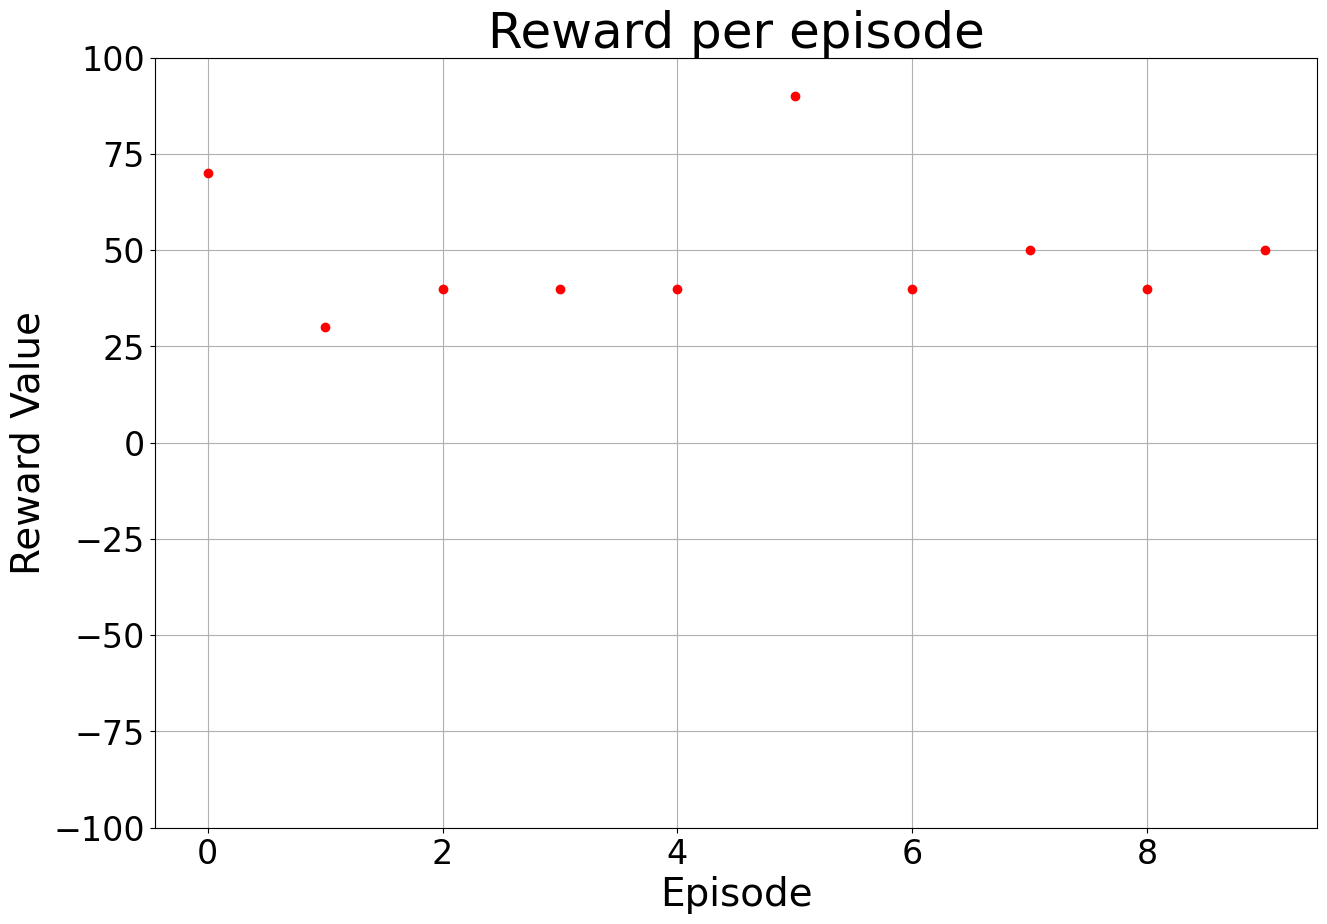

In [6]:
n_episodes_test = 10
test_rewards = []
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)

# Training on 10x10 complex, Testing on 15x15 complex

<Figure size 640x480 with 0 Axes>

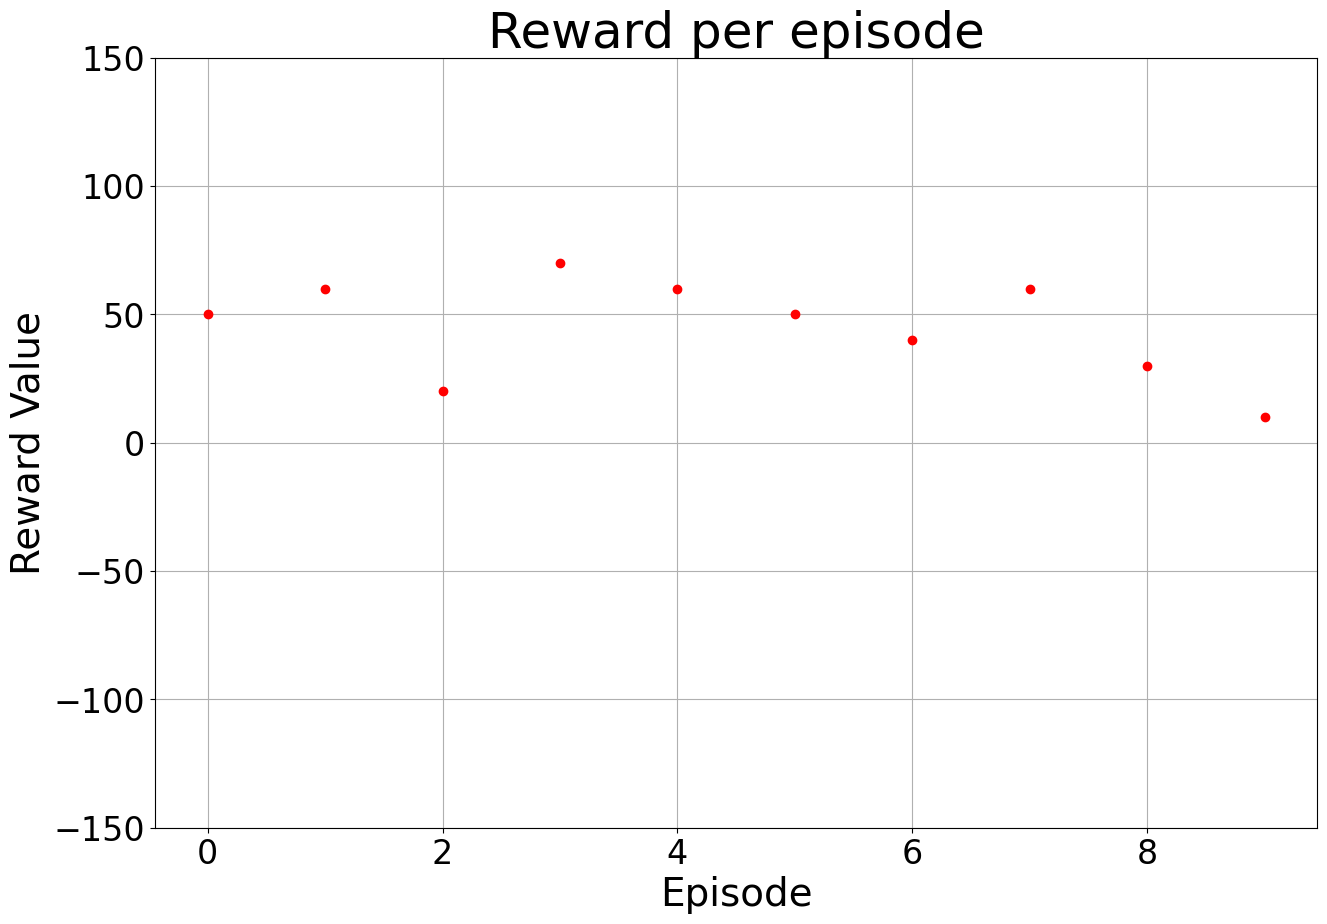

In [8]:
n_episodes_test = 10
test_rewards = []
env = ForestFire(height=15, width=15, obs_type='complex')
min_reward = -150
max_reward = 150
for i in range(n_episodes_test):
    obs = env.reset()
    done = False
    reward = 0
    with torch.no_grad():
        while not done:
            action, log_probability = actor_critic.choose_action(torch.from_numpy(obs).float().unsqueeze(0))
            new_obs, rew, done = env.step(action)
            reward += rew
            obs = new_obs

    test_rewards.append(reward)

plot_test_rewards(environment_name, algorithm_name, test_rewards, min_reward, max_reward, show=True)